## Практическое задание


<ol>
    <li>Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?
    </li> 

MS COCO (Microsoft Common Objects in Context) - ссылка на статью https://arxiv.org/pdf/1405.0312.pdf

####  Особенности датасета
- Это также считающийся сложным датасет (COCO), на котором обучены многие другие модели. Первая версия набора данных MS COCO была выпущена в 2014 году. Он содержит 164K изображений, разделенных на обучающие (83K), валидационные (41K) и тестовые (41K) наборы. В последующие годы размер датасета увеличивался на основе комментариев пользователей, сейчас он содержит 328К изображений, 91 класс объектов  и 2500000 маркированных экземпляров объектов. 
- В отличие от ImageNet, COCO имеет меньше категорий, но больше экземпляров в различных состояниях. Также в отличие от других датасетов объекты находятся в своей естественной среде, контексте (отсюда и название), что важно например при распознавании телефонов в руке, очков на лице. Т.е. изображения в датасете богаты контекстной информацией, а не расположены просто на некотором фоне. 
- Аннтоации к изображениям содержат класс, к которому относится объект, маркировка экземпляров объектов на изображении, сегментирование каждого экземпляра. Эта работа проводилась с помощью Amazon’s Mechanical Turk (AMT) и также прошла верификацию.

####  Использование датасета в моделях 
Одним из направлений исследований является обучение детектора объектов в реальном времени на обычных графических процессорах (GPU), что позволит их использовать повсеместно (даже для обнаружения свободного парковочного места). Этой проблеме посвящено исследование 2020 года (https://arxiv.org/pdf/2004.10934.pdf), целью которго является создание быстро работающего детектора объектов и оптимизация параллельных вычислений на основе модели YOLOv4.  


Архитектура YOLOv4 двухступенчатая (detect -> classify) и на основе множества экспериментов была собрана как:
<li> предтренированый скелет (backbone): CSPDarknet53  (29 CONV слоев 3 × 3) </li>
<li> Шея (neck): SPP (Spatial Pyramid Pooling), модифицированный PAN (Pixel Aggregation Network)  </li>
<li> Голова (head): YOLOv3  </li>

В рамках архитектуры также были впервые представлены
1) новый мозаичный метод аугументации данных (смешивающий не 2, а 4 картинки разного контекста) - улучшение производительности

2) Self-Adversarial Training (SAT)


Эксперименты проводились как раз на датасете COCO. Данная архитектура позволила улучшить результат YOLOv3’s по AP (average accuracy) на 10% до 43.5% на COCO  датасете, frame per second (FPS) на 12%. Туториал авторов выложен в ноутбуке https://colab.research.google.com/drive/12QusaaRj_lUwCGDvQNfICpa7kA7_a2dE. 

Плюсы и минусы YOLO архитектур можно сказать симметричны. Так как их основной целью является сокращение времени на детектирование объекта, приходится смириться с более низкими показателями точности по сравнению с более медленными сетями. На данный момент есть уже Yolo5

# Задание 2

<li>Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.
    </li>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
%matplotlib inline

import cv2 as cv

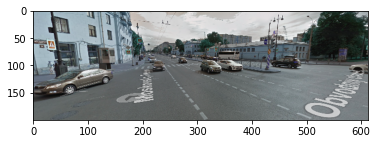

In [2]:
#Читаем картинку
im = cv.imread('streetview2.png')
    
# размеры изображения
newH = 200  #высота
newW = int(im.shape[1]*200/im.shape[0]) # ширина 
#сжатая картинка
im = cv.resize(im, (newW, newH)) 
#Выводим 

plt.imshow(im)
plt.show()

### OpenCV - Selectiv Search

In [3]:
# Объект Selective Search Segmentation
sss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

# запускаем с картинкой
sss.setBaseImage(im)
  
# Выбираем точный метод 
sss.switchToSelectiveSearchQuality()

# Делаем selective search segmentation 
rects = sss.process() 
#вернёт массив прямоугольников, гдевозможно что-то есть
print(rects.shape) #число найденых объектов

(4422, 4)


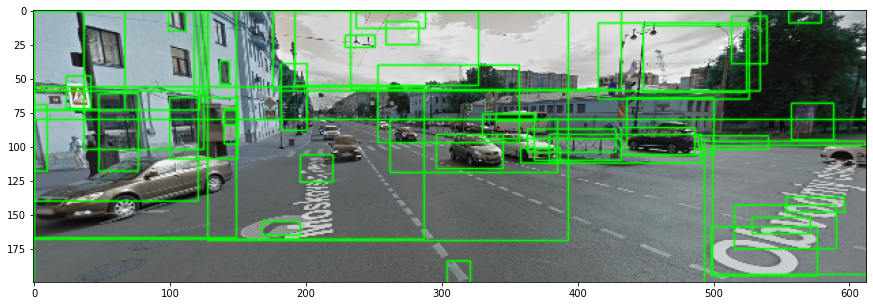

In [4]:
#Построим области

num_Rects = 50 #число выводимых region proposals (прямоугольников)

#создаем копию исходной картинки
im_ = im.copy()

for i, rect in enumerate(rects): 
    if (i < num_Rects): #пока не больше 
        # x,y - координаты левого верхнего угла; w, h - ширина и высота области
        x, y, w, h = rect
    # рисуем рамку      
        cv.rectangle(im_, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA) 
    else: 
        break 

# Рисуем на экран
plt.figure(figsize=(16,5))
plt.imshow(im_) 
plt.show()

### Сравним с результатами FasterRCNN+InceptionResNet V2 (high accuracy)

In [5]:
# выводит картинку
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

#  Грузим и обрабатываем картинку
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    #read image
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    #print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
      # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
        text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
              image_pil,
              ymin,
              xmin,
              ymax,
              xmax,
              color,
              font,
              display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [6]:
root_path = './' #change dir to your project folder 

In [7]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 
#@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", 
# "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [31]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [32]:
def run_detector(detector, path, max_boxes):
    max_boxes = max_boxes
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()
    #print(result['detection_scores'])
    result = {key:value.numpy() for key,value in result.items()} 

    image_with_boxes = draw_boxes(
          img.numpy(), result["detection_boxes"],
          result["detection_class_entities"], result["detection_scores"], max_boxes)

    display_image(image_with_boxes)
    return result

In [33]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    if len(image.shape)>3:
        image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
    I_shape=np.uint8(image).shape
    #print(I_shape)
    im_array=[]
    for i in range(min(boxes.shape[0], max_boxes)):
        #print(tuple(boxes[i]))
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            yminI = np.int(ymin*I_shape[0])
            ymaxI = np.int(ymax*I_shape[0])
            xminI = np.int(xmin*I_shape[1])
            xmaxI = np.int(xmax*I_shape[1])
            imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
            #print(imf.shape,imf[0,0,:])
            im_array.append(imf.copy())  
    return im_array

In [34]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    image_pil = np.array(image)
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
      
            imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
    return imf

In [35]:
import os, fnmatch
listOfFiles = os.listdir(root_path)
pattern = '*.png'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[2]

array('./streetview2.png', dtype='<U17')

### Найдем 10 объектов c FasterRCNN

Font not found, using default font.


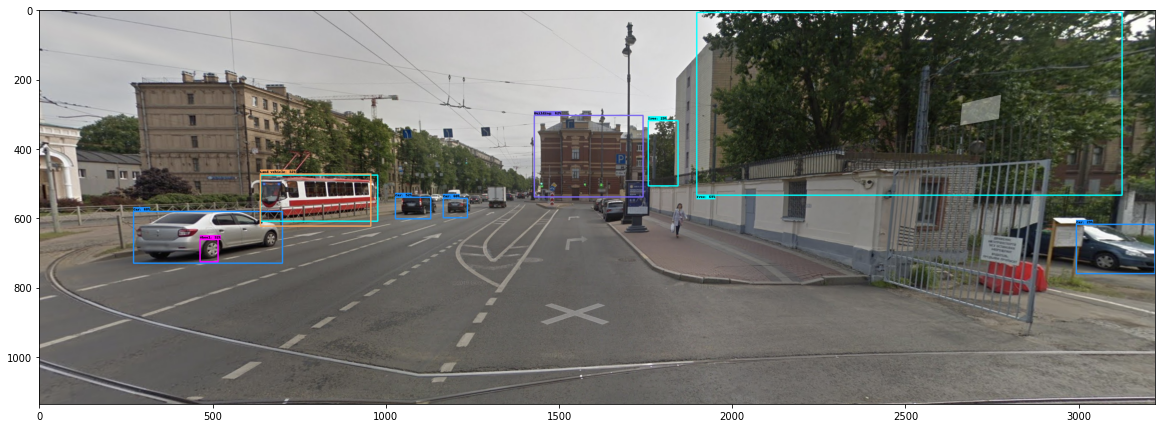

In [36]:
result = run_detector(detector, List_name[1], 10)

Font not found, using default font.


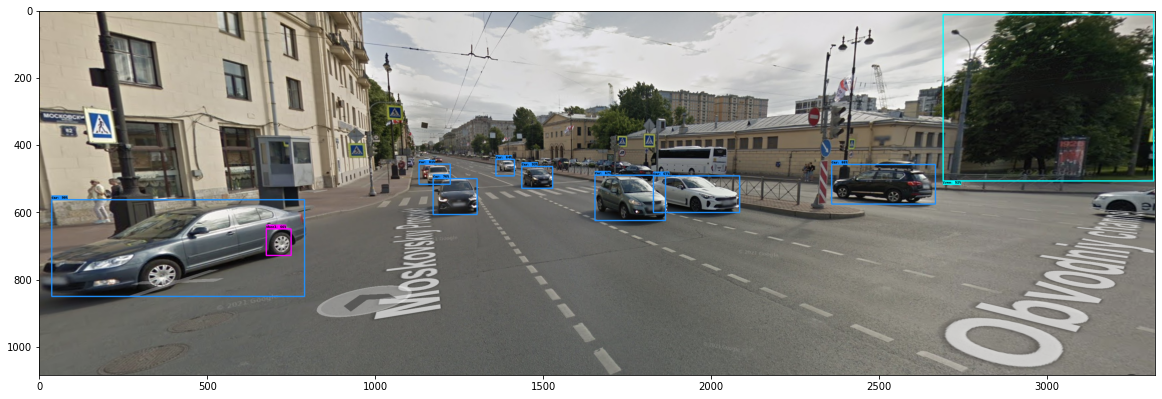

In [37]:
result = run_detector(detector, List_name[2], 10)

In [38]:
result

{'detection_boxes': array([[0.4280125 , 0.43240568, 0.4865747 , 0.46041325],
        [0.51924855, 0.0112332 , 0.783274  , 0.23819843],
        [0.4212726 , 0.34033668, 0.47569057, 0.36861032],
        [0.46074262, 0.35309115, 0.5586688 , 0.39280233],
        [0.45157605, 0.49792016, 0.5750044 , 0.561576  ],
        [0.45322803, 0.550399  , 0.5529244 , 0.62805897],
        [0.59918296, 0.20365845, 0.6715127 , 0.22605763],
        [0.42193207, 0.7102255 , 0.5296897 , 0.8035409 ],
        [0.40839854, 0.4091933 , 0.45292926, 0.42622736],
        [0.01097365, 0.8098792 , 0.46633264, 0.998839  ],
        [0.6783727 , 0.09068219, 0.76957715, 0.12435578],
        [0.        , 0.00658126, 0.59134847, 0.29468733],
        [0.48013604, 0.9417045 , 0.56704354, 1.        ],
        [0.42439565, 0.3386046 , 0.4749578 , 0.3510392 ],
        [0.28755432, 0.7260369 , 0.45047602, 0.8293997 ],
        [0.4650065 , 0.0430856 , 0.59328127, 0.06060152],
        [0.4461546 , 0.5434487 , 0.5306413 , 0.589322

### Найдем 100 объектов c FasterRCNN

Font not found, using default font.


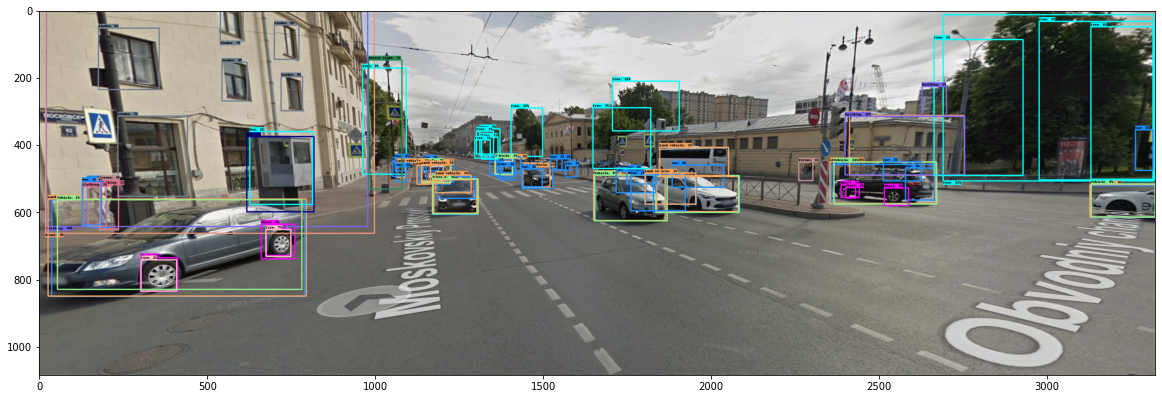

In [39]:
result = run_detector(detector, List_name[2], 100)

Детектор на основе FasterRCNN хорошо распознает автомобили, колеса, деревья, 
В 100 распознанных объектов также попали люди (даже далеко расположенные), фонарные столбы и рекламные щиты, окна домов.

### Найдем 100 объектов c mobilenet

In [40]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" 
#@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", 
# "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Font not found, using default font.


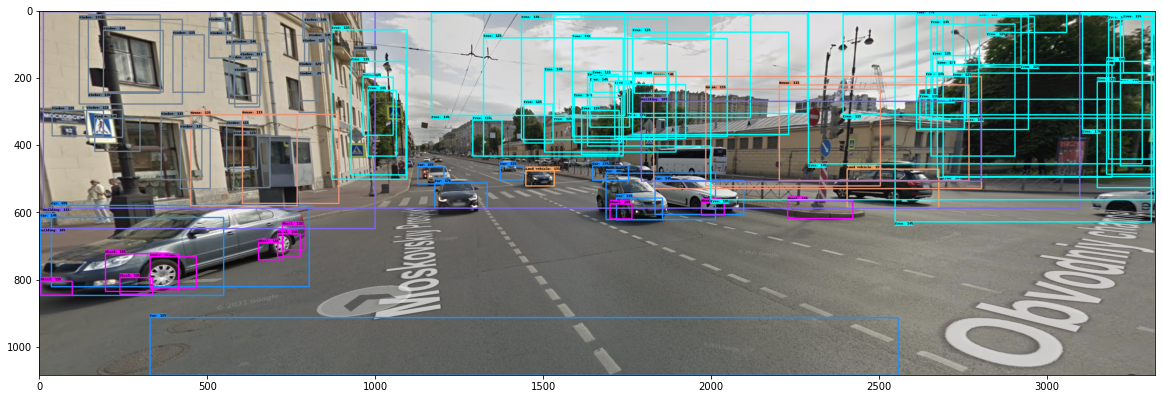

In [41]:
result = run_detector(detector, List_name[2], 100)

По сравнению с mobilenet модель FasterRCNN работает дольше, но точнее распознает объекты. Рамки mobilenet более хаотично определяют объекты, четко не были определены люди (в белой одежде слева на картинке). В то же время mobilenet распознал линии эл.передач